### Portfolio Optimization - Wasserstein Ball and Reinforcement Learning

* [1. Import Packages](#1)
* [2. Stock Simulation Function](#2)  
* [3. ANN for mapping State to action](#3)      
* [4. Function toretun portfolio value and Risk Measure](#4)    
* [5. Training](#5)

<a id='1'></a>
### 1. Import Packages

In [1]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

<a id='2'></a>
### 2. Stock Simulation Function

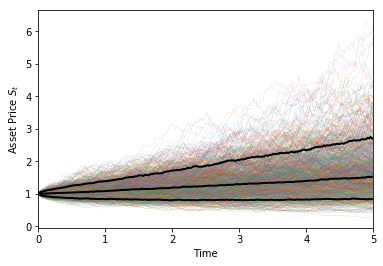

In [2]:
# %%
def SimPath(Ndt, S0, mu, sigma, T, Nsims):
    
    dt = T/Ndt
    
    S = np.zeros((Nsims,Ndt+1))
    S[:,0] = S0
    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.randn(Nsims)
        S[:,i+1] = S[:,i] * np.exp((mu-0.5*sigma**2)*dt + sigma*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        


# %%
t, S = SimPath(252,1, 0.1, 0.2, 5, 1000)

# %%
Ndt=20

S0=1

T=5

Nsims=50


plt.plot(t, S.T,linewidth=0.1)
plt.plot(t,np.quantile(S,[0.1, 0.5, 0.9],axis=0).T,color='k',linewidth=2)
plt.xlabel("Time")
plt.ylabel("Asset Price $S_t$")
plt.xlim([0,5])
plt.show()

<a id='3'></a>
### 3. ANN for mapping state and weights
In this function we pass the prices of the instruments and get the weights across time

In [94]:
# %%
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 3 input layer (t,S), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 4 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 3)
        #self.f_h2_to_out = nn.LogSoftmax(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

<a id='3'></a>
### 3. Helper functions - Risk Measure and Wassterestein function
This function fetches the Return, risk measure and portfolio path for each path

In [4]:
def GetRiskMeasure(Return, Type):
    #TVaR    
    if (Type == "TVaR"):
        percentile = 5
        k = 1 + round(.01 * float(percentile) * (Return[1,:].numel() - 1))
        RiskMeasure =  -1*Return.kthvalue(k).values
        #RiskMeasure = torch.tensor(-1* np.percentile(Return.detach().numpy(), 5,axis=1), dtype=torch.float, requires_grad=True)
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(Return)   
    return RiskMeasure        

In [128]:
def getWassDistance(TotalVal_T, IndexVal_T):
    wass_dist = (TotalVal_T - IndexVal_T)**2
    
    ## Other minimization - Not working correctly   
#     wd = stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())
#     wass_dist = torch.tensor(wd, dtype=torch.float, requires_grad=True)
    return wass_dist  

In [6]:
t, S1 = SimPath(Ndt, 1, .05, .1, T, Nsims)
t, S2 = SimPath(Ndt, 1, .06, .12, T, Nsims)
t, S3 = SimPath(Ndt, 1, .06, .12, T, Nsims)

t

x=np.zeros((Nsims,Ndt+1,4))
x.shape 

x[:,:,0] = np.matlib.repmat(t,Nsims, 1)

x[:,:,1] = S1

x[:,:,2] = S2

x[:,:,3] = S3

xt = torch.tensor(x, dtype=torch.float)

wt= torch.tensor(np.zeros((Nsims,Ndt+1,3)), dtype=torch.float)

wt[:,:-1,:].shape

torch.Size([50, 20, 3])

In [96]:
# wt[:,1:,:] = net(xt[:,:-1,:])
# wt.shape

NameError: name 'constraints' is not defined

In [ ]:
dist.Normal(0, 1)

In [7]:
#Compute wt
#Set the t0 of the portfolio same as index
wt[:,0,:] = Delta_t[:,0,:]

S1.shape

wt[:,:,1].shape

wt 

S1[:,:-1].shape

Val1= wt[:,:,0] * torch.tensor(S1, dtype=torch.float)
Val2= wt[:,:,1] * torch.tensor(S2, dtype=torch.float)
Val3= wt[:,:,2] * torch.tensor(S3, dtype=torch.float)
TotalVal = Val1 + Val2 + Val3

TotalVal.shape

In [8]:
# #Weights at time t 
# #TotalVal[:, -1]

# x2=np.zeros((Nsims,Ndt-1))
# Return = torch.tensor(x2, dtype=torch.float)
# Return.shape

# for i in range(1,Ndt-1):
#     Return[:,i] = TotalVal[:,i+1] - TotalVal[:,i]
        

# wt.shape

# #output for one scenario
# #wt[0,:,:]

# #Weight at T for all scenarios 
# wt[:,-1,:].shape

In [9]:
# Delta_t = torch.tensor(np.zeros((Nsims,Ndt+1,3)), dtype=torch.float)
# Delta_t[:,:,0] = .50
# Delta_t[:,:,1] = .25
# Delta_t[:,:,2] = .25

# Val1_index= Delta_t[:,:,0] * torch.tensor(S1, dtype=torch.float, requires_grad=True)
# Val2_index= Delta_t[:,:,1] * torch.tensor(S2, dtype=torch.float, requires_grad=True)
# Val3_index= Delta_t[:,:,2] * torch.tensor(S2, dtype=torch.float, requires_grad=True)
# TotalVal_index = Val1_index + Val2_index + Val3_index
# #TotalVal_index[:, -1]
# Delta_t[:,-1,:].shape
# #np.array(TotalVal_index.detach())[3]

In [10]:
# Return = TotalVal[:,1:] - TotalVal[:,:-1] 

# #Return at time T across all the scenarios
# Return.shape

In [11]:
# #np.array(TotalVal.detach()).mean(axis =0)

# #np.percentile(Return.detach().numpy(), 5, axis=1)

# RiskMeasure = torch.tensor(np.percentile(Return.detach().numpy(), 5,axis=1), dtype=torch.float, requires_grad=True)
# RiskMeasure

In [12]:
# stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())

# #TotalVal_T

# #stats.wasserstein_distance(1,2)
# #TotalVal_T

# Return.shape

# Return.kthvalue(k).values

# percentile = 5
# k = 1 + round(.01 * float(percentile) * (Return[1,:].numel() - 1))
# Return.kthvalue(k).values

In [13]:
# Return[1,:].numel()

# round(.01 * float(.05) * (Return.numel() - 1))

# wt, Return, TVaR, TotalVal, TotalVal_T, TotalVal_index,IndexVal_T, wass_dist = SimTVaR(net, Ndt, T, Nsims, True)

In [14]:
# #Other minimizations
# #wd = stats.wasserstein_distance(wt[:,-1,0].detach(),Delta_t[:,-1,0].detach())
# #wass_dist = wt-Delta_t
# #wass_dist = wt[:,-1,:] - Delta_t[:,-1,:]
# #wass_dist = (TotalVal_T - IndexVal_T)**2

# #Return at time T across all the scenarios     



# #TVaR   
# percentile = 5
# k = 1 + round(.01 * float(percentile) * (Return[1,:].numel() - 1))
# RiskMeasure =  -1*Return.kthvalue(k).values
# #RiskMeasure = torch.tensor(-1* np.percentile(Return.detach().numpy(), 5,axis=1), dtype=torch.float, requires_grad=True)

In [15]:
# wd = stats.wasserstein_distance(TotalVal_T.detach(),IndexVal_T.detach())
# wass_dist = torch.tensor(wd, dtype=torch.float, requires_grad=True)
# wass_dist

In [16]:
 wt[:,0,:] = torch.tensor(np.matlib.repmat(0,Nsims, 3), dtype=torch.float)

In [17]:
np.matlib.repmat(0,Nsims, 3).shape

(50, 3)

In [54]:
#torch.tensor(np.zeros((Nsims,Ndt+1,3)), dtype=torch.float)

<a id='3'></a>
### 3. Function to get the Return, risk measure and portfolio weights
This function fetches the Return, risk measure and portfolio path for each path

In [110]:
Ndt = 100
S1_T0 = 100
S2_T0 = 100
S3_T0 = 100
Nsims = 50

def SimTVaR(net, Ndt, T, Nsims, ReturnTensor):
    
    #The function is designed for 3 stocks. Can be customized for any number of stocks
    num_asset = 3   
    
    t, S1 = SimPath(Ndt, S1_T0, .05, .1, T, Nsims)
    t, S2 = SimPath(Ndt, S2_T0, .06, .12, T, Nsims)
    t, S3 = SimPath(Ndt, S3_T0, .06, .12, T, Nsims)
    
    #Index Delta and return
    Delta_t = torch.tensor(np.zeros((Nsims,Ndt+1,num_asset)), dtype=torch.float)
    Delta_t[:,:,0] = .50
    Delta_t[:,:,1] = .25
    Delta_t[:,:,2] = .25

    Val1_index= Delta_t[:,:,0] * torch.tensor(S1, dtype=torch.float, requires_grad=True)
    Val2_index= Delta_t[:,:,1] * torch.tensor(S2, dtype=torch.float, requires_grad=True)
    Val3_index= Delta_t[:,:,2] * torch.tensor(S3, dtype=torch.float, requires_grad=True)
    TotalVal_index = Val1_index + Val2_index + Val3_index
    IndexVal_T=TotalVal_index[:, -1]
    
    #Getting the weights for the portfolio
    x=np.zeros((Nsims,Ndt+1,num_asset+1))   
    x[:,:,1] = S1
    x[:,:,2] = S2
    x[:,:,3] = S3
    xt = torch.tensor(x, dtype=torch.float)
    #wt= torch.tensor(np.zeros((Nsims,Ndt+1,3)), dtype=torch.float)
    wt= Delta_t
    wt = net(xt)
    #wt[:,0,:] = torch.tensor(np.matlib.repmat(0,Nsims, 3), dtype=torch.float)
    #wt[:,0,:] = Delta_t[:,0,:]
    Val1= wt[:,:,0] * torch.tensor(S1, dtype=torch.float)
    Val2= wt[:,:,1] * torch.tensor(S2, dtype=torch.float)
    Val3= wt[:,:,2] * torch.tensor(S3, dtype=torch.float)
    TotalVal = Val1 + Val2 + Val3
    TotalVal_T = TotalVal[:,-1]   
    #Compute the return between two consecutive days
    Return = TotalVal[:,1:] - TotalVal[:,:-1]  
    
    
    # Compute the risk measure and wasstertein Distance for the computation
    wass_dist = getWassDistance(TotalVal_T, IndexVal_T)
    #wass_dist = (TotalVal_T - IndexVal_T)
    #wass_dist = 0
    RiskMeasure = GetRiskMeasure(Return, "TVaR")    
    
    return wt, Return, RiskMeasure, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist

<a id='4'></a>
### 4. Training Function

100 Wass Dist: tensor(93357.6719, grad_fn=<SumBackward0>)
Risk Measure: tensor(672.5018, grad_fn=<SumBackward0>)


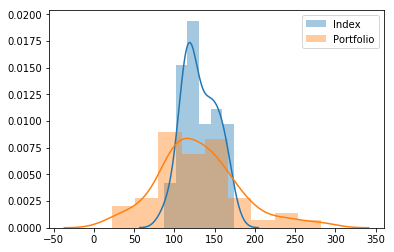

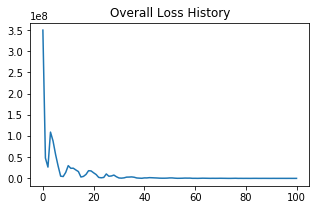

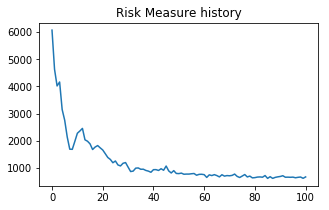

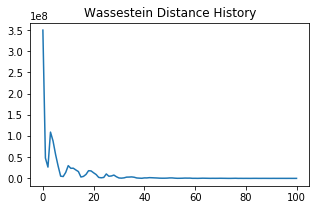

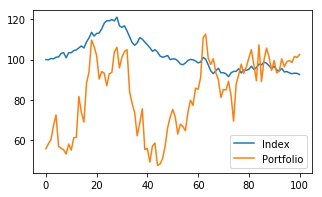

200 Wass Dist: tensor(29838.6777, grad_fn=<SumBackward0>)
Risk Measure: tensor(503.6055, grad_fn=<SumBackward0>)


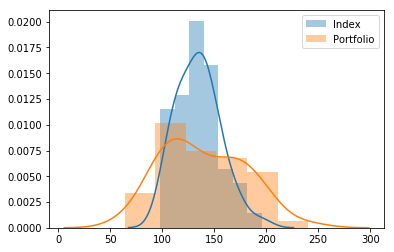

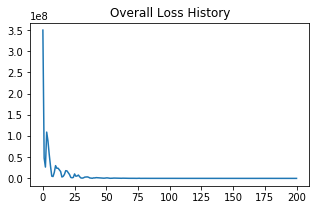

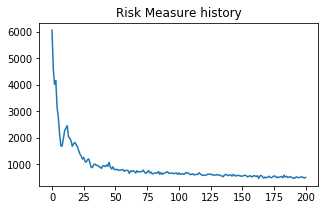

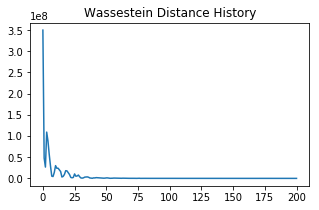

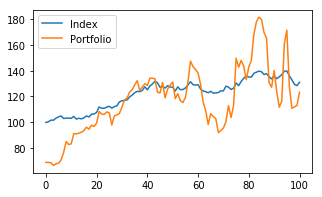

300 Wass Dist: tensor(19434.6699, grad_fn=<SumBackward0>)
Risk Measure: tensor(429.0781, grad_fn=<SumBackward0>)


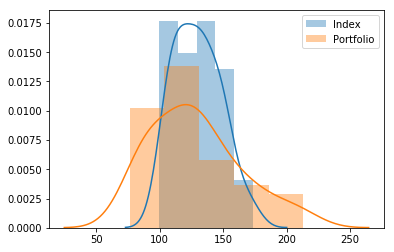

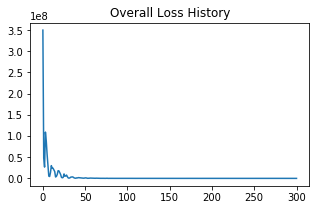

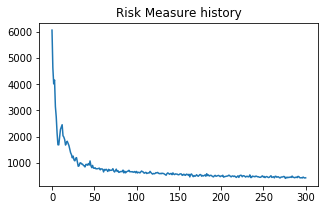

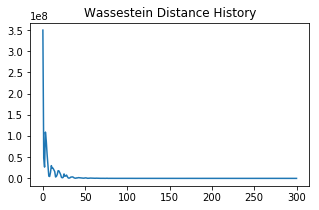

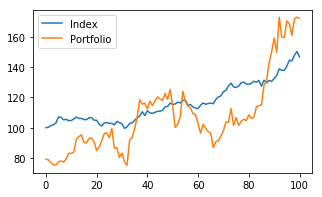

400 Wass Dist: tensor(29065.4121, grad_fn=<SumBackward0>)
Risk Measure: tensor(399.7335, grad_fn=<SumBackward0>)


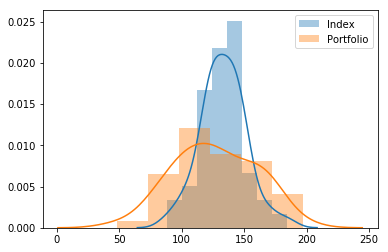

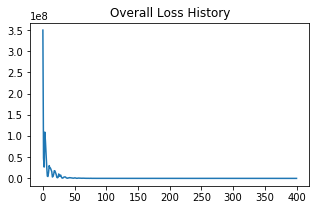

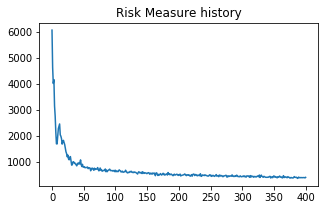

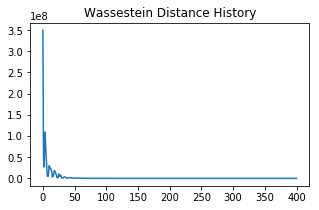

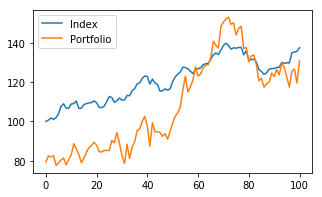

500 Wass Dist: tensor(47777.5508, grad_fn=<SumBackward0>)
Risk Measure: tensor(363.7037, grad_fn=<SumBackward0>)


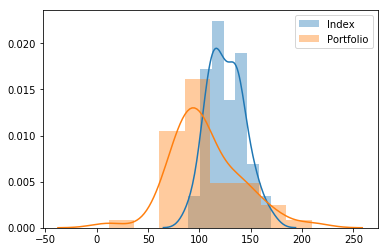

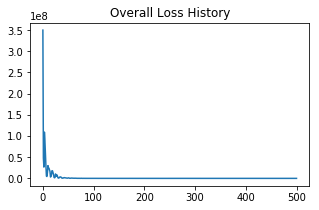

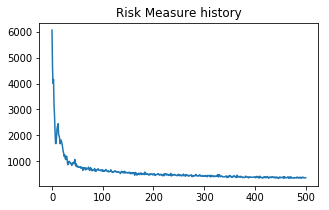

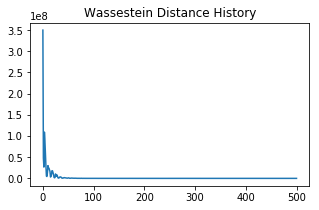

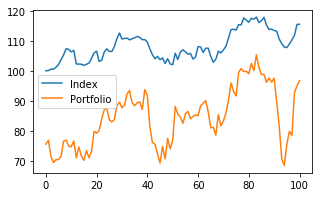

600 Wass Dist: tensor(21487.7148, grad_fn=<SumBackward0>)
Risk Measure: tensor(375.9278, grad_fn=<SumBackward0>)


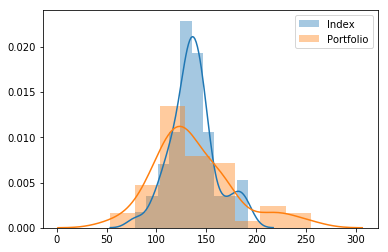

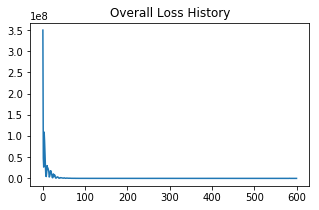

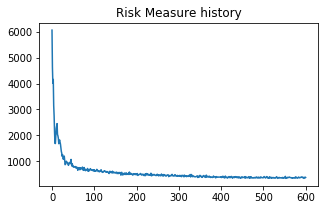

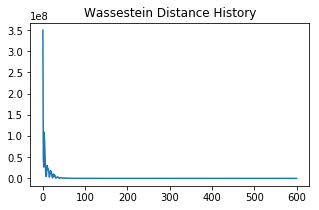

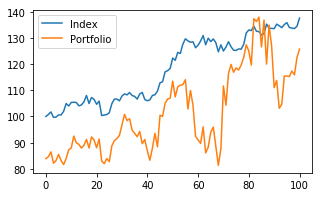

700 Wass Dist: tensor(19611.9141, grad_fn=<SumBackward0>)
Risk Measure: tensor(351.9433, grad_fn=<SumBackward0>)


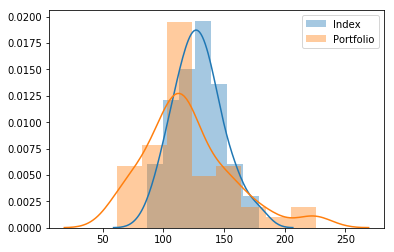

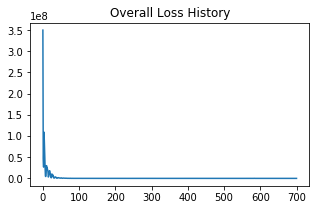

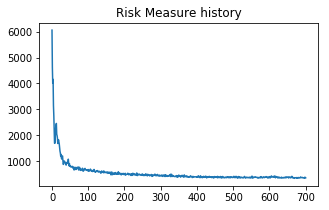

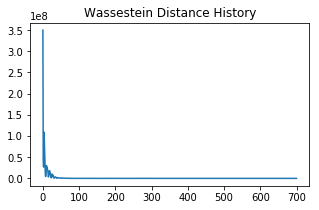

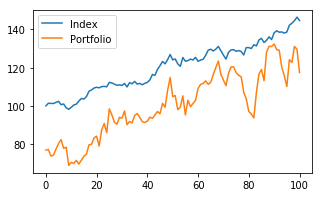

800 Wass Dist: tensor(30595.5527, grad_fn=<SumBackward0>)
Risk Measure: tensor(334.6972, grad_fn=<SumBackward0>)


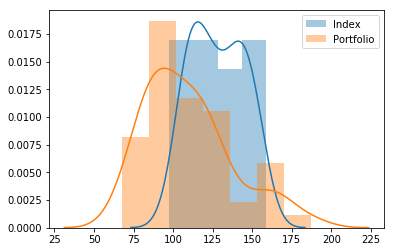

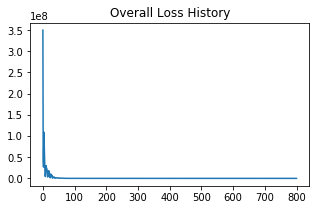

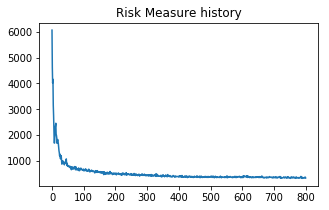

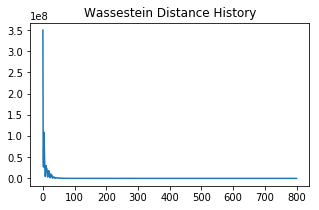

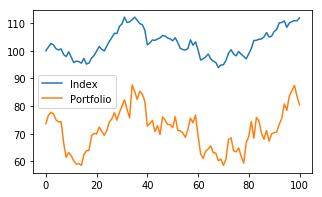

900 Wass Dist: tensor(31568.6133, grad_fn=<SumBackward0>)
Risk Measure: tensor(341.8396, grad_fn=<SumBackward0>)


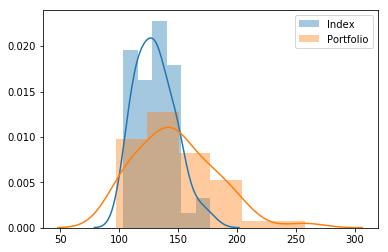

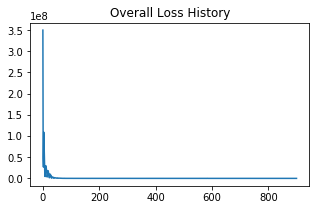

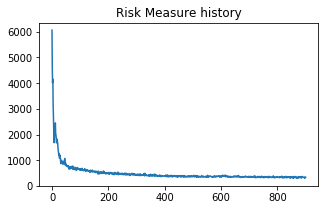

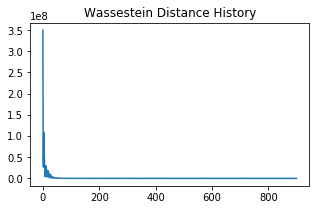

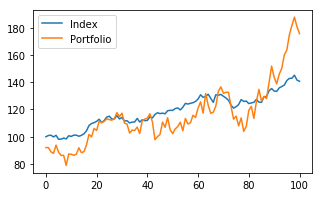

Finished Training


In [131]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print('Using device:', device)
#net.to(device)

#print(net)

#Create object of the class
net = MyNet(80)

# create  optimizer
optimizer = optim.Adam(net.parameters())


Nepochs = 1000
loss_hist = []
risk_history = []
wass_dist_history=[]

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    wt, Return, RiskMeasure, TotalVal, TotalVal_index, TotalVal_T, IndexVal_T, wass_dist = SimTVaR(net, Ndt, T, Nsims, True)
    
    #print (S )
    #error = wass_dist + TVaR
    #print (error )
    regularization_param = 1
    #loss = torch.sum(RiskMeasure)
    loss = regularization_param*torch.sum(wass_dist) + torch.sum(RiskMeasure)
    #loss = torch.sum(RiskMeasure) 
    #loss = torch.sum(-TVaR)
    #print (wt) 
    loss.backward()   
    
    #print (wt, Return, TVaR ) 
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append(torch.sum(RiskMeasure))
    wass_dist_history.append(torch.sum(wass_dist))
    # plot output every 50 iterations
    if( (epoch % 100 == 0) and (epoch>1) ):
        print(epoch,end=" ")
        #print(loss.item())
        print("Wass Dist:", torch.sum(wass_dist))
        print("Risk Measure:", torch.sum(RiskMeasure))
        sns.distplot(np.array(IndexVal_T.detach()), hist=True, kde=True, label='Index')
        sns.distplot(np.array(TotalVal_T.detach()), hist=True, kde=True, label='Portfolio')
        plt.legend()
        plt.figure(figsize=(5,3))
        plt.title("Overall Loss History") 
        plt.plot(loss_hist)
        plt.show()
        plt.figure(figsize=(5,3))
        plt.plot(risk_history)
        plt.title("Risk Measure history") 
        plt.show()
        plt.figure(figsize=(5,3))
        plt.plot(wass_dist_history)
        plt.title("Wassestein Distance History") 
        plt.show()
        
        plt.figure(figsize=(5,3))
        plt.rcParams['figure.facecolor'] = 'white'
        plt.plot(np.array(TotalVal_index.detach())[2], label='Index')
        plt.plot(np.array(TotalVal.detach())[2], label='Portfolio')
        plt.legend()
        plt.show()

print('Finished Training')

### Final Weights 

In [107]:
wt

tensor([[[ 8.1485, -5.1639, -2.2500],
         [ 8.2505, -5.1826, -2.2927],
         [ 8.6645, -5.6119, -2.6999],
         ...,
         [12.6119, -7.9850, -2.5434],
         [12.7599, -8.2368, -2.7115],
         [12.6094, -8.0218, -2.5728]],

        [[ 8.1485, -5.1639, -2.2500],
         [ 8.2461, -5.1542, -2.2721],
         [ 8.3297, -5.1345, -2.0605],
         ...,
         [12.6537, -7.0530, -0.9038],
         [13.0110, -7.2757, -0.9569],
         [13.3966, -7.4819, -0.6832]],

        [[ 8.1485, -5.1639, -2.2500],
         [ 8.2616, -5.4160, -2.4158],
         [ 8.1586, -5.3920, -2.3429],
         ...,
         [14.0755, -9.8454, -6.0876],
         [13.9297, -9.6611, -5.7704],
         [14.0366, -9.6241, -5.2489]],

        ...,

        [[ 8.1485, -5.1639, -2.2500],
         [ 8.3574, -5.3496, -2.2823],
         [ 8.3508, -5.1704, -2.0296],
         ...,
         [12.3280, -7.2467, -1.6126],
         [12.0733, -7.1505, -1.7317],
         [11.8987, -6.9277, -1.4437]],

        [[